The following codes are from https://github.com/Computational-Content-Analysis-2020/Content-Analysis-2020. 

# Data Preprocessing
In this section, I will explore the corpus to decide how to preprocess the data. By counting high-frequency words, I will detect stop words that are frequent but do not embody significant meaning for the analysis. Also, N-gram score and Named Entity Recognition will be implemented to find meaningful collocations that need to be combined in the corpus. 

## Data preparation

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

In [51]:
# Loading the data. There is no row missing an abstract in this file.
df = pandas.read_csv("/Users/daejin/MA_thesis_content_analysis_scholarly_articles/Data/WOS_1846_3.csv")

### Tokenizing the abstracts
To count the frequency of words, the abstracts need to be tokenized into words.

In [52]:
nlp = spacy.load("en")

In [53]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [54]:
# Making a 'tokenized_text' column 
df['tokenized_text']=df['AB'].apply(lambda x: word_tokenize(x))

## Stop words & Collocations


### High-frequency words

In [61]:
#Adding word frequency as a column
df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))


In [16]:
countsDict = {}
for word in df['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

[('and', 13234),
 ('the', 12338),
 ('of', 11899),
 ('in', 7724),
 ('to', 6732),
 ('a', 4268),
 ('that', 3407),
 ('with', 3118),
 ('for', 3056),
 ('were', 2337),
 ('cultural', 2108),
 ('The', 2064),
 ('on', 2032),
 ('as', 1802),
 ('is', 1762),
 ('was', 1756),
 ('are', 1578),
 ('self', 1567),
 ('from', 1498),
 ('Asian', 1467),
 ('their', 1459),
 ('more', 1410),
 ('culture', 1373),
 ('than', 1244),
 ('by', 1220),
 ('between', 1119),
 ('this', 1091),
 ('be', 1069),
 ('social', 1045),
 ('differences', 1039),
 ('an', 969),
 ('not', 913),
 ('cultures', 913),
 ('or', 877),
 ('among', 873),
 ('In', 863),
 ('Chinese', 828),
 ('groups', 754),
 ('these', 746),
 ("'s", 745),
 ('This', 719),
 ('students', 718),
 ('have', 692),
 ('women', 649),
 ('but', 647),
 ('may', 622),
 ('which', 618),
 ('group', 615),
 ('associated', 609),
 ('both', 593)]

As expected, there are many high-frequency words, such as 'and', 'the', 'of', 'in', and etc., that do not add any meaning to the analysis. I will remove these by normalizing the texts.

### Normalizing the texts

In [17]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [18]:
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))
df['normalized_tokens_count'] = df['normalized_tokens'].apply(lambda x: len(x))

In [19]:
countsDict = {}
for word in df['normalized_tokens'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

[('culture', 2346),
 ('cultural', 2189),
 ('self', 1591),
 ('asian', 1467),
 ('group', 1396),
 ('difference', 1242),
 ('social', 1104),
 ('high', 851),
 ('chinese', 828),
 ('student', 816),
 ('child', 765),
 ('relationship', 737),
 ('family', 679),
 ('woman', 676),
 ('experience', 644),
 ('sample', 633),
 ('report', 631),
 ('individual', 629),
 ('effect', 615),
 ('support', 610),
 ('associate', 602),
 ('western', 592),
 ('ethnic', 592),
 ('suggest', 589),
 ('find', 578),
 ('value', 555),
 ('emotion', 552),
 ('american', 530),
 ('present', 526),
 ('east_asian', 521),
 ('level', 518),
 ('acculturation', 510),
 ('influence', 508),
 ('analysis', 504),
 ('behavior', 497),
 ('low', 493),
 ('ed', 491),
 ('compare', 474),
 ('parent', 470),
 ('relate', 468),
 ('different', 460),
 ('positive', 454),
 ('psychological', 452),
 ('asian_american', 445),
 ('use', 443),
 ('symptom', 440),
 ('age', 440),
 ('cross', 434),
 ('role', 432),
 ('perceive', 429)]

Now, the meaningless functional words are removed from the data. This list is reviewed to select stop words. 

### Collocations
The ultimate goal of this part is to know what words need to be merged as one expression. For instance, "Asian" needs to be distinguished from "Asian American" since they indicate different population. This requires Asian American to be one expression such as Asian_American. To locate collocations, the corpus need to be processed first by removing insignificant high-frequency words and normalizing the data.

In [25]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))


There are 198748 bigrams in the finder


In [26]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('asian', 'american'), ('east', 'asian'), ('n', '='), ('asian', 'americans'), ('cultural', 'difference'), ('mental', 'health'), ('study', 'examine'), ('cross', 'cultural'), ('united', 'states'), ('european', 'americans')]


In [27]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:100]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('n', '='), 5653.743007453043),
 (('united', 'states'), 4361.911755433267),
 (('mental', 'health'), 3677.079402055009),
 (('east', 'asian'), 3084.8887218257487),
 (('asian', 'american'), 2664.332230799008),
 (('right', 'reserve'), 2520.914014465003),
 (('asian', 'americans'), 2410.517461602735),
 (('cultural', 'difference'), 2287.5548965875532),
 (('cross', 'cultural'), 2230.5014796162222),
 (('self', 'construal'), 2054.5155681135116),
 (('european', 'americans'), 2037.2191512746977),
 (('hong', 'kong'), 1976.893789350532),
 (('east', 'asians'), 1915.152120204433),
 (('study', 'examine'), 1688.9789750645887),
 (('c', 'elsevier'), 1625.2023537602536),
 (('self', 'esteem'), 1611.4325977723418),
 (('depressive', 'symptom'), 1377.0655880739328),
 (('college', 'student'), 1265.4417741818866),
 (('ethnic', 'group'), 1181.3877798008575),
 (('european', 'american'), 1089.4117540751552),
 (('eat', 'disorder'), 1084.6092608558963),
 (('present', 'study'), 1017.7379527371783),
 (('ltd', 'right'

In [31]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(df['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:30]

[(('east', 'asian', 'culture'), 9.782852619894378),
 (('mental', 'health', 'service'), 9.11017100978478),
 (('ltd', 'right', 'reserve'), 8.888182744399385),
 (('interdependent', 'self', 'construal'), 8.602127691862613),
 (('american', 'college', 'student'), 8.061317235987714),
 (('asian', 'american', 'woman'), 8.053233725968676),
 (('elsevier', 'ltd', 'right'), 7.999988412408697),
 (('c', 'elsevier', 'ltd'), 7.745945594870553),
 (('present', 'study', 'examine'), 7.741861806656573),
 (('cross', 'cultural', 'difference'), 7.611720579296046),
 (('inc', 'right', 'reserve'), 7.483304458486054),
 (('elsevier', 'inc', 'right'), 6.92819327540826),
 (('c', 'elsevier', 'inc'), 6.928185680973451),
 (('asian', 'american', 'college'), 6.851945004843498),
 (('americans', 'asian', 'americans'), 6.765800683120815),
 (('john', 'wiley', 'sons'), 6.708203448159473),
 (('c', 'john', 'wiley'), 6.633245858133241),
 (('hong', 'kong', 'chinese'), 6.557385710633458),
 (('m', 'age', '='), 6.403029433893928),
 (

In [32]:
quadgram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.QuadgramCollocationFinder.from_words(df['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:30]

[(('elsevier', 'ltd', 'right', 'reserve'), 7.998041697069755),
 (('c', 'elsevier', 'ltd', 'right'), 7.741873768824461),
 (('elsevier', 'inc', 'right', 'reserve'), 6.926520857710299),
 (('c', 'elsevier', 'inc', 'right'), 6.924798665676089),
 (('c', 'john', 'wiley', 'sons'), 6.63308206472066),
 (('john', 'wiley', 'sons', 'ltd'), 5.656782454934615),
 (('copyright', 'c', 'john', 'wiley'), 5.47706778576597),
 (('national', 'latino', 'asian', 'american'), 4.494660974189922),
 (('elsevier', 'b.v', 'right', 'reserve'), 4.471463356194193),
 (('c', 'elsevier', 'b.v', 'right'), 4.357502466852059),
 (('m', 'age', '=', 'year'), 4.202148926496128),
 (('independent', 'interdependent', 'self', 'construal'), 4.043135916666147),
 (('c', 'wiley', 'periodicals', 'inc'), 3.8727899976930007),
 (('c', 'elsevi', 'science', 'ltd'), 3.7411546781457745),
 (('ltd', 'right', 'reserve', 'study'), 3.6700342558484498),
 (('discuss', 'c', 'elsevier', 'inc'), 3.5891625545014616),
 (('=', 'm', 'age', '='), 3.47507050750

Among these collocations, I reviewed which ones are meaningful when they are merged. I included the list of the joined collocations in the appendix of the thesis. 

### NER (Named Entity Recognition)
I will use the Named Entity Recognition (NER) to find what countries/ethnicities are included in the corpus.

In [24]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [25]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [26]:
df['sentences'] = df['AB'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

df['classified_sents'] = df['sentences'].apply(lambda x: tag_sents_ner(x))

In [28]:
nonObjCounts = {}
for entry in df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:200]

[('Asian', 1417),
 ('Chinese', 763),
 ('two', 479),
 ('East Asian', 467),
 ('American', 400),
 ('Americans', 334),
 ('three', 329),
 ('Asian American', 319),
 ('Asian Americans', 286),
 ('2', 272),
 ('Japanese', 263),
 ('European Americans', 244),
 ('Western', 229),
 ('East Asians', 228),
 ('Asians', 226),
 ('first', 187),
 ('four', 181),
 ('1', 173),
 ('3', 169),
 ('European American', 155),
 ('Korean', 145),
 ('South Asian', 142),
 ('English', 141),
 ('one', 140),
 ('Caucasian', 135),
 ('European', 129),
 ('Indian', 120),
 ('second', 100),
 ('Canadian', 96),
 ('4', 89),
 ('Australian', 89),
 ('Hispanic', 86),
 ('Westerners', 79),
 ('Latino', 75),
 ('five', 73),
 ('Confucian', 72),
 ('Koreans', 66),
 ('N', 63),
 ('Canadians', 62),
 ('Asia', 58),
 ('Two', 56),
 ('six', 55),
 ('Taiwanese', 55),
 ('British', 55),
 ('North American', 54),
 ('daily', 52),
 ('Chinese American', 52),
 ('Caucasians', 50),
 ('Eastern', 49),
 ('North Americans', 49),
 ('Vietnamese', 48),
 ('Findings', 47),
 ('A

Some of the entities are also included as collocations. The list is also in the appendix.

# Loading the preprocessed data
From here, the preprocessed data are used. 

In [2]:
newdf = pandas.read_csv("/Users/daejin/MA_thesis_content_analysis_scholarly_articles/Data/WOS_1846_4.csv")

In [4]:
nlp = spacy.load("en")

In [5]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [6]:
newdf['tokenized_text']=newdf['AB'].apply(lambda x: word_tokenize(x))

In [7]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [8]:
newdf['normalized_tokens'] = newdf['tokenized_text'].apply(lambda x: normalizeTokens(x))
newdf['normalized_tokens_count'] = newdf['normalized_tokens'].apply(lambda x: len(x))

# NER

To find what national and ethnic entities exist in the literature, NER was examined again with the preprocessed data. 

In [22]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [23]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [24]:
newdf['sentences'] = newdf['AB'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

newdf['classified_sents'] = newdf['sentences'].apply(lambda x: tag_sents_ner(x))

In [25]:
nonObjCounts = {}
for entry in newdf['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:200]

[('Asian', 1207),
 ('Chinese', 745),
 ('two', 463),
 ('2', 320),
 ('three', 314),
 ('asian_american', 310),
 ('American', 281),
 ('Japanese', 256),
 ('asian_americans', 242),
 ('Western', 231),
 ('1', 226),
 ('Asians', 224),
 ('european_americans', 209),
 ('Americans', 193),
 ('east_asians', 189),
 ('3', 187),
 ('first', 186),
 ('four', 171),
 ('mental_health', 152),
 ('Korean', 141),
 ('English', 139),
 ('one', 132),
 ('Caucasian', 129),
 ('Indian', 120),
 ('4', 102),
 ('second', 98),
 ('European', 96),
 ('Australian', 92),
 ('Canadian', 84),
 ('Westerners', 81),
 ('Hispanic', 79),
 ('Confucian', 73),
 ('Latino', 73),
 ('Koreans', 67),
 ('east_asian', 62),
 ('five', 62),
 ('British', 58),
 ('european_american', 58),
 ('Asia', 57),
 ('Taiwanese', 55),
 ('Two', 54),
 ('six', 53),
 ('daily', 53),
 ('Caucasians', 52),
 ('Eastern', 50),
 ('Vietnamese', 48),
 ('Canadians', 48),
 ('north_american', 47),
 ('5', 46),
 ('north_americans', 44),
 ('Three', 43),
 ('body_image', 42),
 ('ed', 37),
 

# Lexical dispersion
Lexical dispersion shows where words are located in the corpus. The corpus used for this analysis is arranged by the year of publication, providing some insight of how words evolved over time. 

In order to get the lexical dispersion, the corpus needs to be combined as one list of words.

In [177]:
list_token=newdf['tokenized_text']

In [178]:
new_list = [' '.join(i) for i in list_token]

In [62]:
tokenized_sents = [word_tokenize(i) for i in new_list]

In [63]:
flat_token = [inner
                for outer in tokenized_sents
                     for inner in outer]

In [64]:
import nltk
whText = nltk.Text(flat_token)

/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

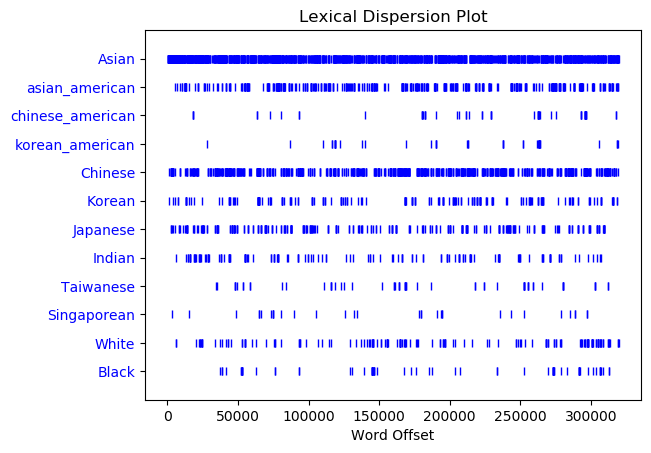

In [65]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Asian','asian_american','chinese_american','korean_american','Chinese','Korean','Japanese','Indian','Taiwanese','Singaporean', 'White','Black'])
sns.set() #Re-enabling seaborn

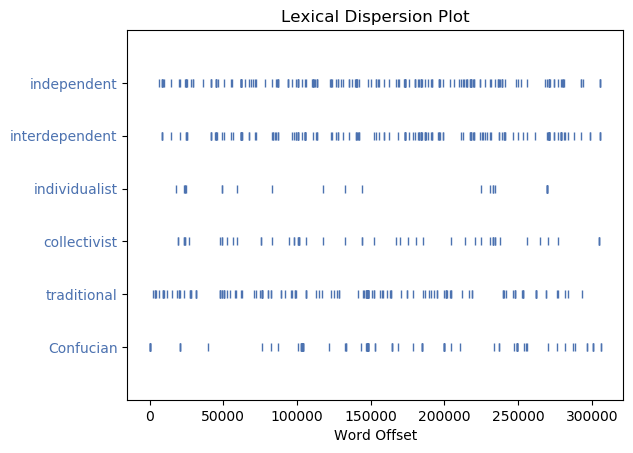

In [183]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['independent','interdependent','individualist','collectivist','traditional','Confucian'])

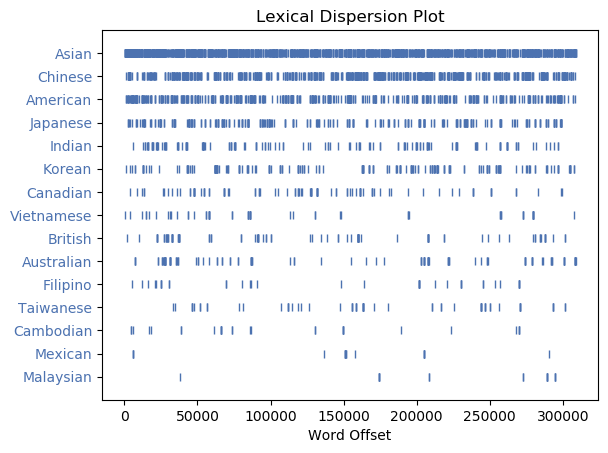

In [32]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Asian','Chinese','American','Japanese','Indian','Korean','Canadian','Vietnamese','British','Australian','Filipino','Taiwanese','Cambodian','Mexican','Malaysian'])
sns.set() #Re-enabling seaborn

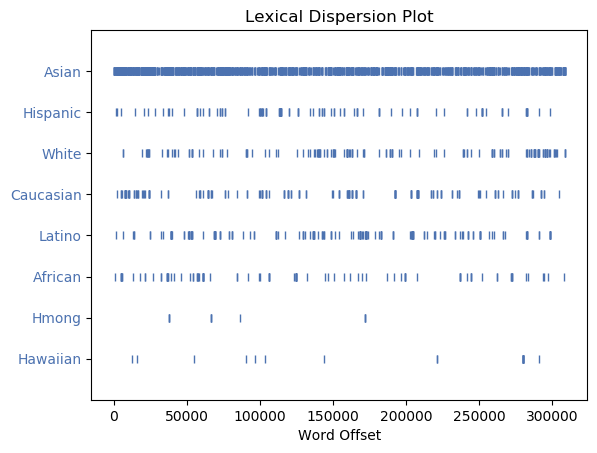

In [33]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Asian','Hispanic','White','Caucasian','Latino','African','Hmong','Hawaiian'])
sns.set() #Re-enabling seaborn

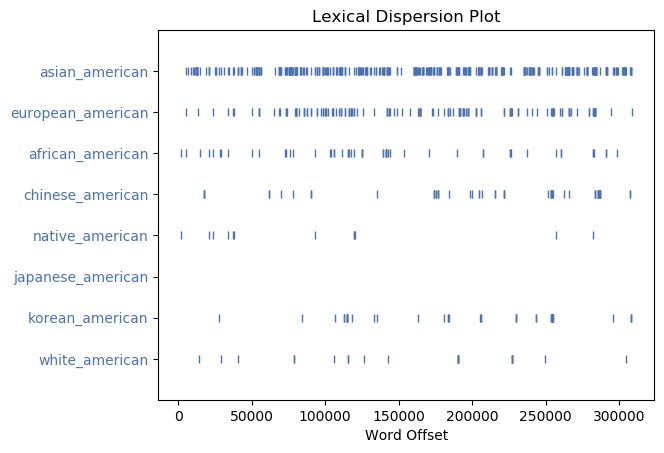

In [34]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['asian_american','european_american','african_american','chinese_american','native_american','japanese_american','korean_american','white_american'])
sns.set() #Re-enabling seaborn

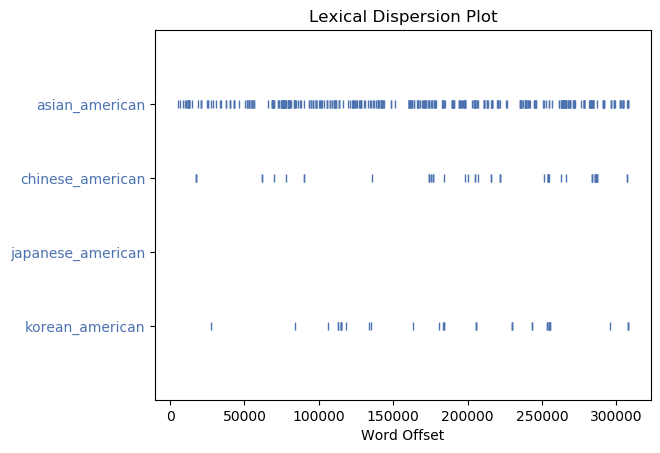

In [35]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['asian_american','chinese_american','japanese_american','korean_american'])
sns.set() #Re-enabling seaborn

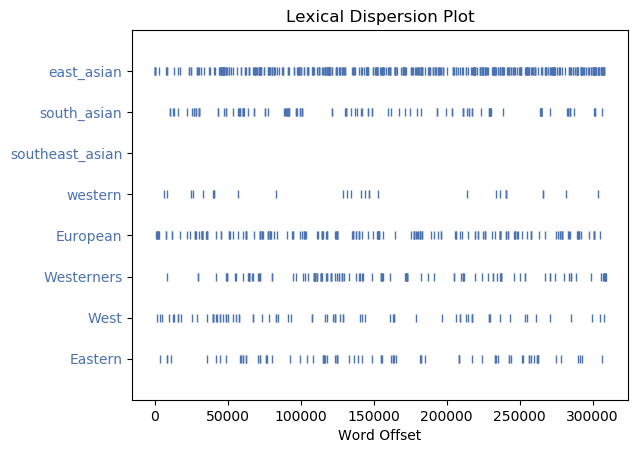

In [36]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['east_asian','south_asian','southeast_asian','western','European','Westerners','West','Eastern'])
sns.set() #Re-enabling seaborn

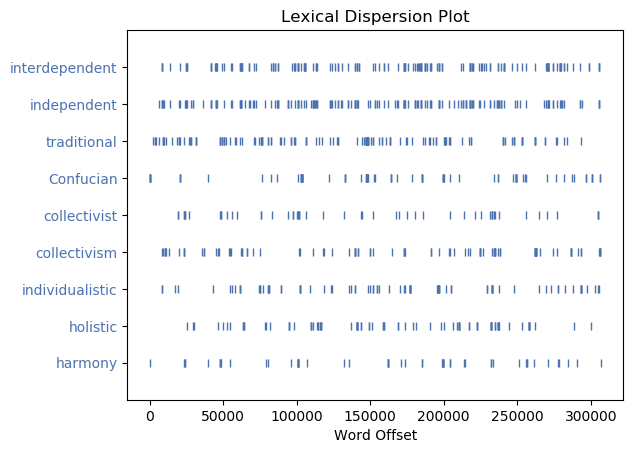

In [275]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['interdependent','independent','traditional','Confucian','collectivist','collectivism','individualistic','holistic','harmony'])
sns.set() #Re-enabling seaborn

# Semantic Network Analysis
In this study, semantic network was built by connecting collocated words in the same sentences. To do this, the data need to be processed by sentence. 

In [23]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [24]:
newdf['tokenized_sents'] = newdf['AB'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
newdf['normalized_sents'] = newdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])


In [25]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [51]:
g = wordCooccurrence(newdf['normalized_sents'][:1842].sum())

## Reducing low-frequency edges
Given the amount of the data, there are too many edges and nodes to visualize. Thus, edges of which weights are 100 times or less will be removed

In [52]:
#changing the weight:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 100])


In [53]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [54]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [55]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 151
Average degree:   4.4412


## Visualization: edge weight > 100

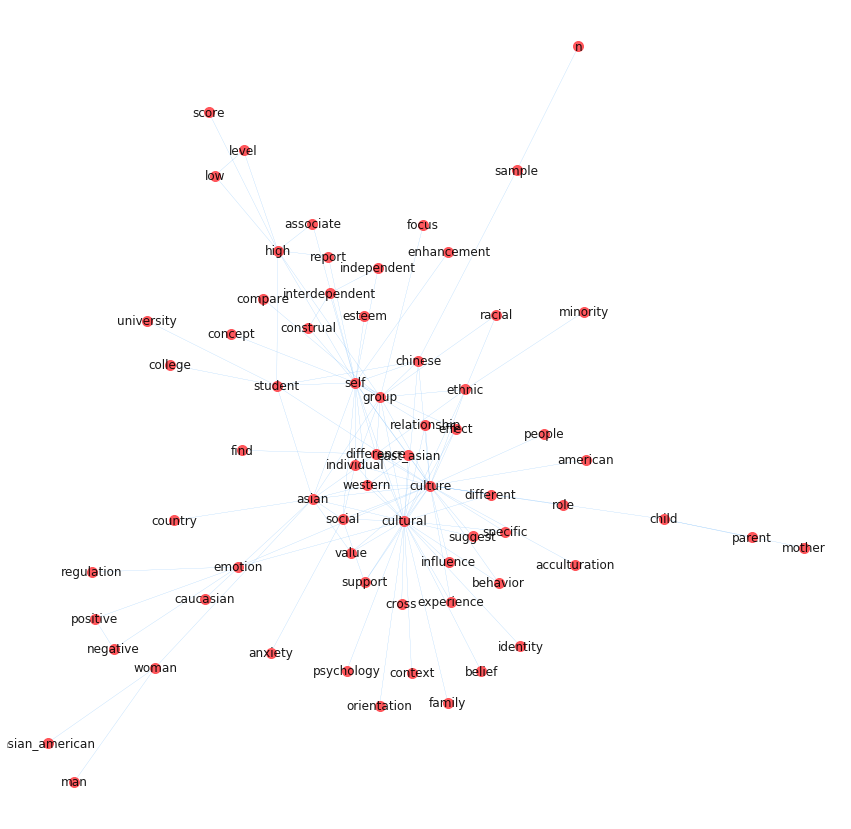

In [56]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

To better understand the network, each clique (smaller network) will be demonstrated

In [57]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

cultural, culture, self, asian, difference, group


## Examining cliques

As the network above is too large to grasp, smaller networks will be visualized by selecting a few words at the center.

### "Culture"

In [58]:
cultureNeighbors = giant.neighbors('culture')
g_cultureNeighbors = giant.subgraph(cultureNeighbors)
print(nx.info(g_cultureNeighbors))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 92
Average degree:   6.3448


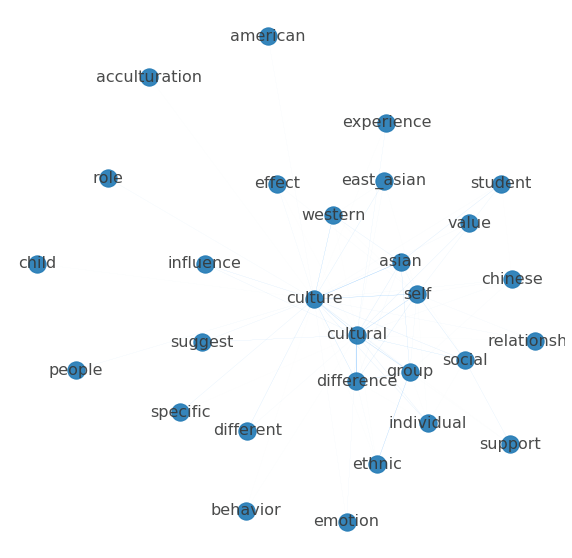

In [59]:
layout_amer = nx.spring_layout(g_cultureNeighbors, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_cultureNeighbors.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_cultureNeighbors.edges(data = True)))
nx.draw(g_cultureNeighbors, ax = ax, pos = layout_amer, labels = {n:n for n in g_cultureNeighbors.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_cultureNeighbors.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

### "Asian"

In [60]:
asianNeighbors = giant.neighbors('asian')
g_asian = giant.subgraph(asianNeighbors)
print(nx.info(g_asian))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 41
Average degree:   6.3077


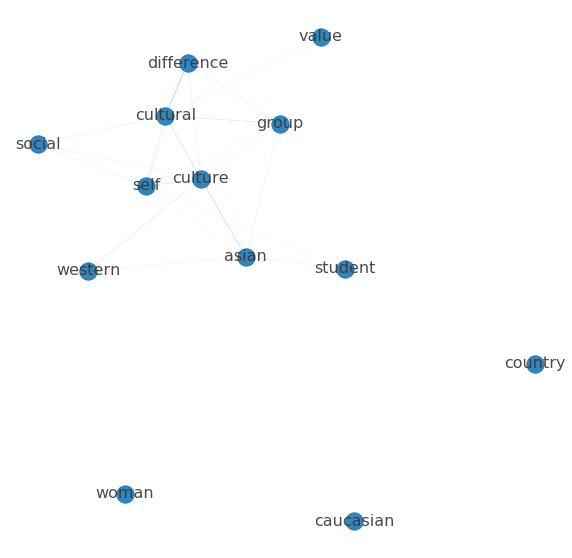

In [61]:
layout_amer = nx.spring_layout(g_asian, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_asian.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_asian.edges(data = True)))
nx.draw(g_asian, ax = ax, pos = layout_amer, labels = {n:n for n in g_asian.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_asian.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

### "Self"

In [62]:
selfNeighbors = giant.neighbors('self')
g_selfNeighbors = giant.subgraph(selfNeighbors)
print(nx.info(g_selfNeighbors))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 76
Average degree:   6.6087


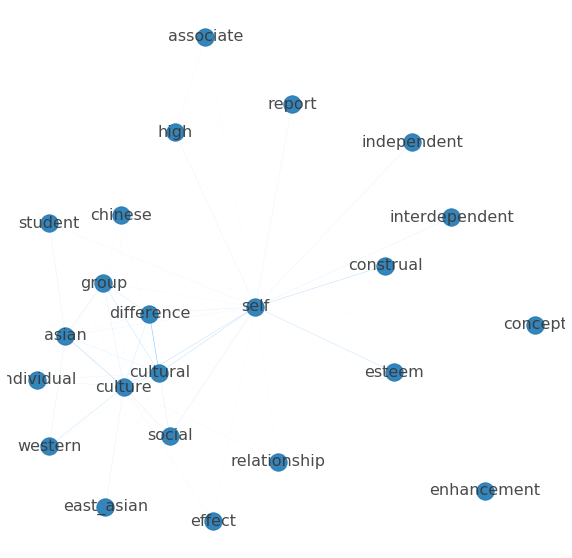

In [63]:
layout_amer = nx.spring_layout(g_selfNeighbors, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_selfNeighbors.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_selfNeighbors.edges(data = True)))
nx.draw(g_selfNeighbors, ax = ax, pos = layout_amer, labels = {n:n for n in g_selfNeighbors.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_selfNeighbors.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

### "Individual"

In [78]:
indiNeighbors = giant.neighbors('individual')
g_indiNeighbors = giant.subgraph(indiNeighbors)
print(nx.info(g_indiNeighbors))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 26
Average degree:   7.4286


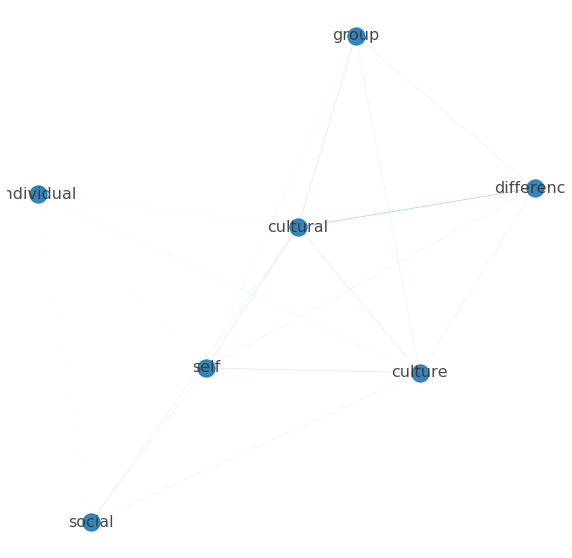

In [79]:
layout_amer = nx.spring_layout(g_indiNeighbors, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_indiNeighbors.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_indiNeighbors.edges(data = True)))
nx.draw(g_indiNeighbors, ax = ax, pos = layout_amer, labels = {n:n for n in g_indiNeighbors.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_indiNeighbors.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Word Embedding: Word2vec

In [10]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [13]:
newdfW2V = gensim.models.word2vec.Word2Vec(newdf['normalized_sents'].sum())

## Similar words

This section calculates similarity scores between words and finds similar words. However, this section is not reported in the paper. 

In [90]:
newdfW2V.similarity('traditional', 'collectivist')

0.99767506

In [91]:
newdfW2V.similarity('traditional', 'individualistic')

0.9969023

In [92]:
newdfW2V.similarity('traditional', 'independent')

0.8582202

In [93]:
newdfW2V.similarity('traditional', 'holistic')

0.99243844

In [94]:
newdfW2V.similarity('korean', 'asian')

0.9722475

In [95]:
newdfW2V.similarity('vietnamese', 'asian')

0.902539

In [96]:
newdfW2V.most_similar('interdependent', topn=30)

[('independent', 0.9895772933959961),
 ('construal', 0.9794195294380188),
 ('self', 0.96893310546875),
 ('esteem', 0.9594664573669434),
 ('rosenberg', 0.9492648839950562),
 ('positive', 0.9361658096313477),
 ('enhancement', 0.9357960224151611),
 ('predict', 0.9343224167823792),
 ('negative', 0.9321063756942749),
 ('efficacy', 0.930754542350769),
 ('emotional', 0.9275326728820801),
 ('scs', 0.9218629002571106),
 ('perceive', 0.9210983514785767),
 ('control', 0.9174798727035522),
 ('relationship', 0.9162509441375732),
 ('emotion', 0.9159745573997498),
 ('effacement', 0.914618968963623),
 ('affect', 0.9138778448104858),
 ('positively', 0.9128120541572571),
 ('mediate', 0.912581741809845),
 ('satisfaction', 0.911833643913269),
 ('monitoring', 0.9105876684188843),
 ('concept', 0.9088302254676819),
 ('actualization', 0.9014261960983276),
 ('personal', 0.9009131193161011),
 ('relate', 0.9002965688705444),
 ('doubt', 0.8995223045349121),
 ('suppression', 0.8982484340667725),
 ('humility', 0.89

In [97]:
newdfW2V.most_similar('independent')

[('interdependent', 0.9895772933959961),
 ('rosenberg', 0.9732369780540466),
 ('enhancement', 0.9696359634399414),
 ('efficacy', 0.9662481546401978),
 ('scs', 0.9590690732002258),
 ('control', 0.954513430595398),
 ('monitoring', 0.9523308873176575),
 ('effacement', 0.947890043258667),
 ('esteem', 0.9468609690666199),
 ('concept', 0.9460828900337219)]

In [98]:
newdfW2V.most_similar('value')

[('individual', 0.9934877753257751),
 ('context', 0.9921638369560242),
 ('cognitive', 0.9902944564819336),
 ('orientation', 0.9890953898429871),
 ('importance', 0.9890176057815552),
 ('norm', 0.9886883497238159),
 ('relation', 0.9884827733039856),
 ('effect', 0.9880815148353577),
 ('cognition', 0.9848756194114685),
 ('expression', 0.9848554134368896)]

In [99]:
newdfW2V.most_similar('collectivist', topn=20)

[('attribute', 0.9989864826202393),
 ('individualist', 0.9989793300628662),
 ('modulate', 0.9989213943481445),
 ('judgment', 0.9989066123962402),
 ('orient', 0.998887300491333),
 ('give', 0.9988566040992737),
 ('serve', 0.9988242983818054),
 ('interdependence', 0.9987971186637878),
 ('b', 0.9987946152687073),
 ('representation', 0.9987571835517883),
 ('encourage', 0.9987436532974243),
 ('individualism', 0.9987390637397766),
 ('moral', 0.9987252950668335),
 ('acceptance', 0.9987218379974365),
 ('distinguish', 0.9986979961395264),
 ('autonomy', 0.9986940026283264),
 ('sensitivity', 0.9986540079116821),
 ('independence', 0.998649001121521),
 ('action', 0.9986469149589539),
 ('possess', 0.9986222982406616)]

In [100]:
newdfW2V.most_similar('culture')

[('different', 0.9882694482803345),
 ('contexts', 0.9773603081703186),
 ('people', 0.9756565093994141),
 ('context', 0.975315272808075),
 ('individual', 0.9729560613632202),
 ('perspective', 0.9719226360321045),
 ('suggest', 0.9709680080413818),
 ('identity', 0.9701962471008301),
 ('value', 0.9692083597183228),
 ('play', 0.9686499238014221)]

In [101]:
newdfW2V.most_similar('asian')

[('sample', 0.9815373420715332),
 ('american', 0.9795730710029602),
 ('university', 0.978773832321167),
 ('kong', 0.9783051013946533),
 ('adult', 0.977176308631897),
 ('latino', 0.9766988158226013),
 ('white', 0.9750213623046875),
 ('hong', 0.9747511148452759),
 ('chinese', 0.9745236039161682),
 ('immigrant', 0.9743219614028931)]

In [102]:
newdfW2V.most_similar('european')

[('non', 0.9961625337600708),
 ('indian', 0.9958354234695435),
 ('u.s', 0.9949382543563843),
 ('south', 0.9947468042373657),
 ('live', 0.9945796728134155),
 ('korea', 0.993720531463623),
 ('british', 0.993351936340332),
 ('generation', 0.9931659698486328),
 ('china', 0.9930492639541626),
 ('participate', 0.9930075407028198)]

In [103]:
newdfW2V.most_similar('chinese')

[('american', 0.98960942029953),
 ('university', 0.989310622215271),
 ('female', 0.9885860085487366),
 ('complete', 0.9864997863769531),
 ('sample', 0.9862421751022339),
 ('college', 0.984833836555481),
 ('white', 0.9836922883987427),
 ('adult', 0.9831981658935547),
 ('old', 0.9827466011047363),
 ('hispanic', 0.9824972152709961)]

In [104]:
newdfW2V.most_similar('chinese_american', topn=20)

[('household', 0.9991315007209778),
 ('girl', 0.998935341835022),
 ('month', 0.998725414276123),
 ('api', 0.9984692931175232),
 ('hawaiian', 0.9984031915664673),
 ('subject', 0.9983863830566406),
 ('boy', 0.998374342918396),
 ('acculturate', 0.9983534216880798),
 ('gamble', 0.9982902407646179),
 ('cambodian', 0.9981576800346375),
 ('counterpart', 0.9980725049972534),
 ('latina', 0.9980247020721436),
 ('caucasian_american', 0.997978687286377),
 ('spend', 0.9978994131088257),
 ('survivor', 0.9978269338607788),
 ('english', 0.9978073835372925),
 ('elderly', 0.9977779388427734),
 ('california', 0.9977567195892334),
 ('korean_american', 0.997713029384613),
 ('taiwanese', 0.9976950287818909)]

In [105]:
newdfW2V.most_similar('american')

[('university', 0.9922170042991638),
 ('hispanic', 0.9898600578308105),
 ('chinese', 0.98960942029953),
 ('european_american', 0.9887062311172485),
 ('australian', 0.9863470792770386),
 ('white', 0.9856343865394592),
 ('undergraduate', 0.9856128692626953),
 ('korean', 0.9855989813804626),
 ('canadian', 0.9854040145874023),
 ('kong', 0.9848672151565552)]

In [106]:
newdfW2V.most_similar('european')

[('non', 0.9961625337600708),
 ('indian', 0.9958354234695435),
 ('u.s', 0.9949382543563843),
 ('south', 0.9947468042373657),
 ('live', 0.9945796728134155),
 ('korea', 0.993720531463623),
 ('british', 0.993351936340332),
 ('generation', 0.9931659698486328),
 ('china', 0.9930492639541626),
 ('participate', 0.9930075407028198)]

In [107]:
newdfW2V.most_similar('traditional', topn=100)

[('generalize', 0.9988662600517273),
 ('religion', 0.9988309741020203),
 ('particular', 0.9986398220062256),
 ('share', 0.9986398220062256),
 ('tradition', 0.998570442199707),
 ('encourage', 0.998565137386322),
 ('preference', 0.9985302686691284),
 ('respect', 0.9985103607177734),
 ('unique', 0.9984371662139893),
 ('salient', 0.9984328150749207),
 ('exposure', 0.9983206987380981),
 ('connection', 0.9983192682266235),
 ('maintain', 0.9983167052268982),
 ('idea', 0.9983055591583252),
 ('prone', 0.9982940554618835),
 ('confucian', 0.9982864856719971),
 ('shift', 0.9982820749282837),
 ('ideology', 0.9982804656028748),
 ('product', 0.9982693195343018),
 ('evolve', 0.9982496500015259),
 ('necessarily', 0.998248815536499),
 ('trust', 0.9982395172119141),
 ('reality', 0.9982336163520813),
 ('largely', 0.998221218585968),
 ('aware', 0.9982104301452637),
 ('intergroup', 0.9982068538665771),
 ('root', 0.9981579780578613),
 ('world', 0.9981553554534912),
 ('learning', 0.9981346130371094),
 ('west'

In [108]:
newdfW2V.most_similar('korean')

[('undergraduate', 0.9967565536499023),
 ('male', 0.9957370758056641),
 ('adolescent', 0.9949941039085388),
 ('european_american', 0.9946570992469788),
 ('australian', 0.9946484565734863),
 ('latino', 0.993914783000946),
 ('m', 0.9935635328292847),
 ('hispanic', 0.9931809306144714),
 ('canadian', 0.9924468398094177),
 ('caucasian', 0.9921067953109741)]

In [109]:
newdfW2V.doesnt_match(['chinese', 'korean', 'japanese', 'vietnamese','indian', 'chinese_american', 'white', 'caucasian'])


'chinese'

This shows the least similar word to the rest of the words in the list. 

In [110]:
newdfW2V.most_similar(positive=[ 'asian'], negative = ['white'])


[('cross', 0.43112894892692566),
 ('western', 0.32167717814445496),
 ('cultural', 0.3148977756500244),
 ('culture', 0.26909536123275757),
 ('difference', 0.2536965608596802),
 ('different', 0.22767657041549683),
 ('east_asian', 0.22156968712806702),
 ('implication', 0.19650501012802124),
 ('provide', 0.17838749289512634),
 ('psychology', 0.17611311376094818)]

In [111]:
newdfW2V.most_similar(positive=[ 'interdependent'], negative = ['independent'], topn=20)


[('self', 0.2964174747467041),
 ('construal', 0.2478044033050537),
 ('esteem', 0.08730833977460861),
 ('positive', 0.04742521047592163),
 ('social', 0.01690385490655899),
 ('negative', 0.011243283748626709),
 ('emotion', 0.009909220039844513),
 ('associate', -0.0535605251789093),
 ('predict', -0.07744236290454865),
 ('relationship', -0.0994490534067154),
 ('emotional', -0.11198820918798447),
 ('cultural', -0.12347053736448288),
 ('affect', -0.1285875141620636),
 ('relate', -0.13069750368595123),
 ('psychological', -0.13444265723228455),
 ('satisfaction', -0.14187242090702057),
 ('mediate', -0.14235369861125946),
 ('level', -0.14726461470127106),
 ('anxiety', -0.15191183984279633),
 ('rosenberg', -0.16603495180606842)]

## Semantic Space
Semantic space analysis will be done with 70 words. 

### Dimension reduction

In [19]:
numWords = 70
targetWords = newdfW2V.wv.index2word[:numWords]

In [20]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(newdfW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.59711206,  0.23836045,  0.15737076, ...,  0.06692404,
         0.2229184 ,  0.20189175],
       [ 0.70457757,  0.15256748,  0.25916538, ..., -0.27018365,
         0.14024916,  0.25268933],
       [ 1.1780316 ,  0.01371276,  0.69986415, ...,  0.1579775 ,
         0.3227293 ,  0.22989945],
       ...,
       [ 0.5926494 ,  0.02923092,  0.38225046, ...,  0.3106687 ,
         0.5632235 ,  0.10210359],
       [ 0.41743216,  0.22080891,  0.26755372, ...,  0.28540066,
         0.584347  ,  0.15686792],
       [ 0.5090004 ,  0.12907083,  0.24248563, ...,  0.11538806,
         0.332534  ,  0.1762662 ]], dtype=float32)

In [21]:
pcaWords = sklearn.decomposition.PCA(n_components = 70).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

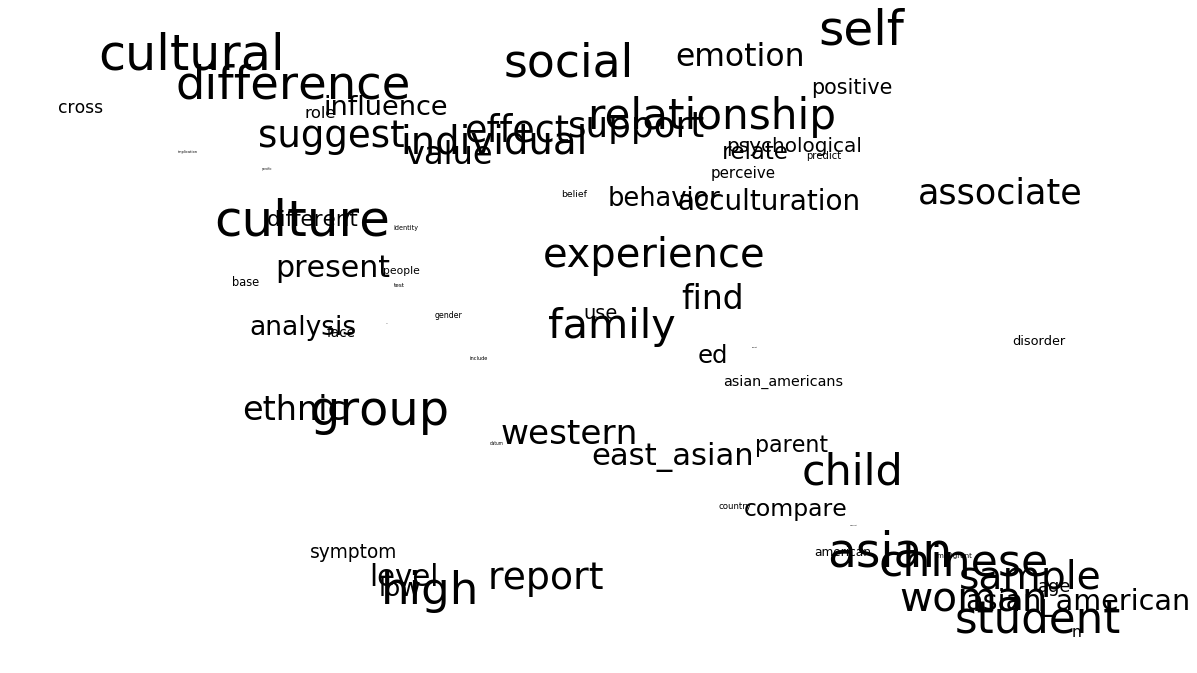

In [22]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  50 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

## Word2Vec

In [87]:
#words to create dimensions
tnytTargetWords = ['black', 'white','european', 'caucasian', 'asian', 'american','chinese', 'korean', 'japanese', 'indian', 'singaporean','vietnamese','chinese_american','korean_american','asian_american','european_american','east_asian','south_asian']
#words we will be mapping
tnytTargetWords += ["value","personality","relationship","culture","independent", "interdependent","traditional","tradition","modern","confucian", "depression", "industry", "urban", "rural",'middle']


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(newdfW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [88]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 33).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

### Visualizing the semantic space

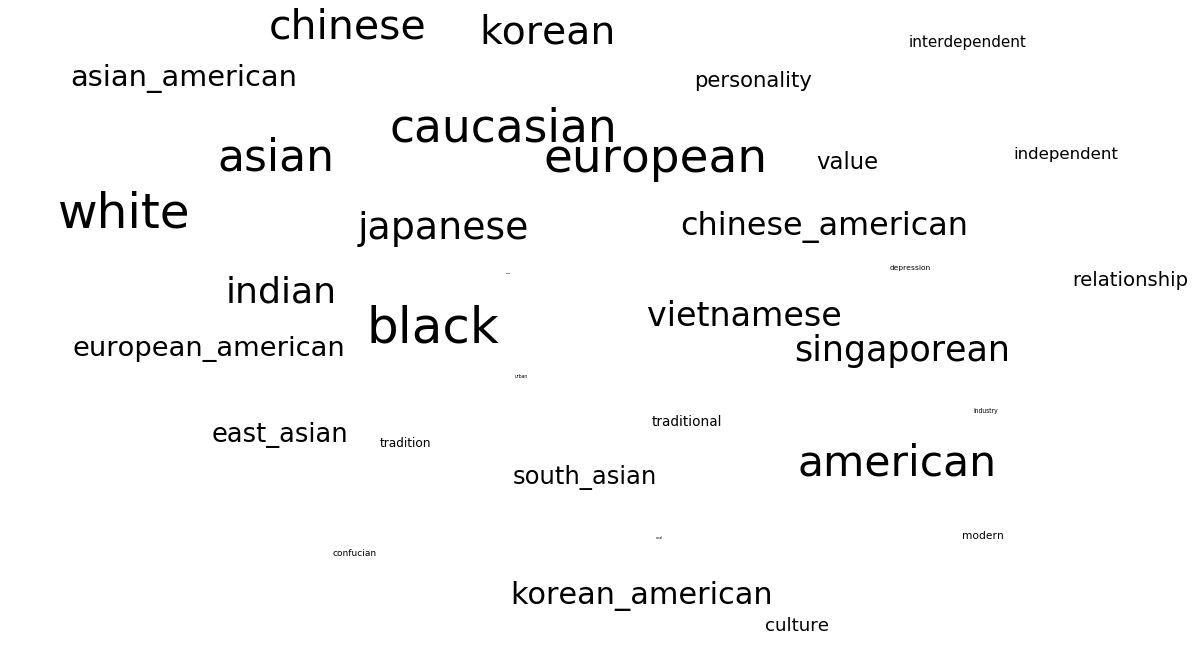

In [89]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

### Dimensionality: country, race, immigrants

In [116]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [117]:
cultural_traits = dimension(newdfW2V, ['interdependent','traditional','tradition','confucian','holistic','collectivist'],['independent','individualistic','objective'])

In [118]:
characteristic1 =['chinese','japanese','indian','korean','vietnamese','canadian','european_american','asian_american']


In [119]:
def makeDF(model, word_list):
    g = []
    #r = []
    #c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(senReleasesW2V[word].reshape(1,-1), cultural_traits.reshape(1,-1))[0][0])
        #r.append(sklearn.metrics.pairwise.cosine_similarity(senReleasesW2V[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        #c.append(sklearn.metrics.pairwise.cosine_similarity(senReleasesW2V[word].reshape(1,-1), Immigrants.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'cultural_traits': g}, index = word_list)
    return df

In [120]:
df_1 = makeDF(newdfW2V, characteristic1) 
#df_2 = makeDF(senReleasesW2V, characteristic2)
#Sportsdf = makeDF(nytimes_model, Sports)

In [121]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

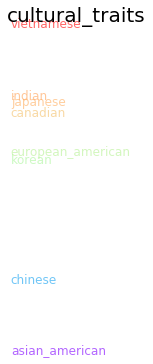

In [122]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, df_1, 'cultural_traits')


# Comparison (week 4)

In [30]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

#This will be doing most of the work
import networkx as nx


In [21]:
newdf['tokenized_sents'] = newdf['AB'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
newdf['normalized_sents'] = newdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [22]:
newdf_1=newdf[1:880]
newdf_2=newdf[881:1842]

In [23]:
whWords = set(newdf_1['normalized_tokens'].sum())
kenWords = set(newdf_2['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

2588

In [24]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(newdf_1['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(newdf_2['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

0.9999999999999999

## KL divergence 

In [25]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.12289272336528681
0.12105882796674311


## Elementwise divergence

In [26]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,n=90,5.141632e-07
1,predispose,7.288359e-05
2,n=55,5.141632e-07
3,ethnicitie,2.653977e-05
4,idealized,9.874834e-06
5,indebtedness,3.638280e-05
6,mate,2.325159e-06
7,essential,8.543706e-07
8,customer,8.134481e-05
9,foreground,1.022129e-07


In [27]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
4197,author,0.001392
521,violence,0.001157
3112,subject,0.000988
724,woman,0.000956
1604,esteem,0.000810
2110,event,0.000651
697,emotion,0.000630
1896,self,0.000612
3753,asian,0.000536
3925,teenager,0.000513


## newdf1

In [31]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [32]:
g = wordCooccurrence(newdf_1['normalized_sents'][:879].sum())


In [36]:
#changing the weight: removing edges with weights of 80 or below
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 80])


In [37]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [38]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [39]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 36
Average degree:   4.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


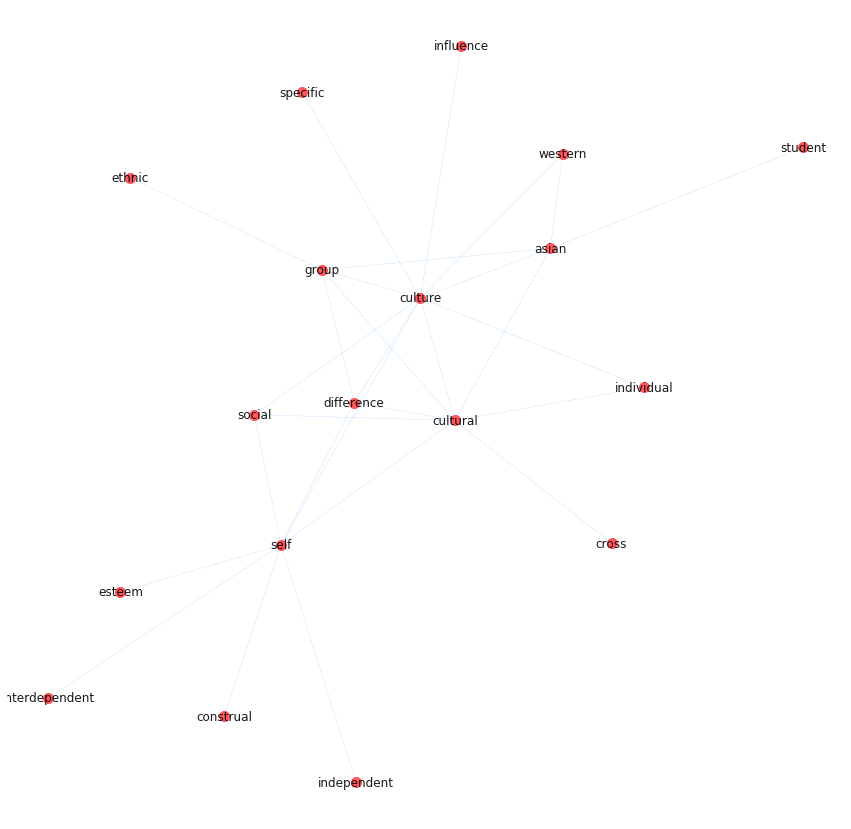

In [40]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

## newdf2

In [41]:
g = wordCooccurrence(newdf_2['normalized_sents'][:961].sum())


In [46]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 80])


In [47]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [48]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 65
Average degree:   3.7143


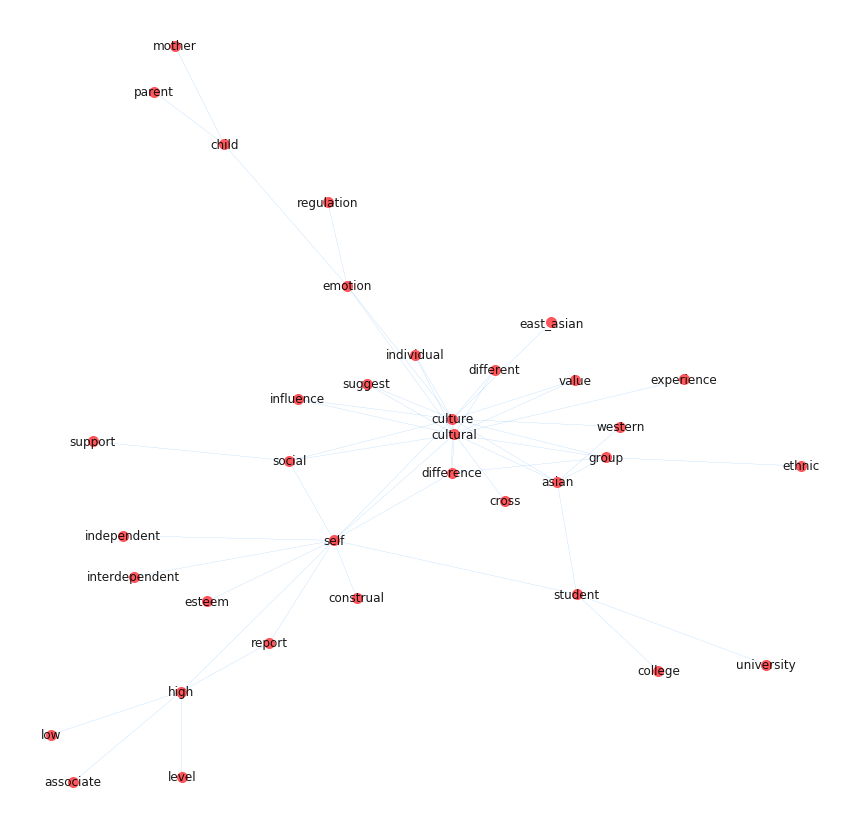

In [49]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

# Descriptive data
For this section, I will create a bar graph for the publication years.

In [11]:
year=newdf['PY']

In [12]:
def count_elements(seq) -> dict:
    """Tally elements from `seq`."""
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(year)

In [13]:
lists = sorted(counted.items()) # sorted by key, return a list of tuples


In [14]:
pandas.DataFrame(lists)

,0,1
0,1990,1
1,1991,1
2,1992,7
3,1993,12
4,1994,26
5,1995,27
6,1996,12
7,1997,25
8,1998,40
9,1999,39


Text(0.5, 1.0, '# of Articles Published by Year')

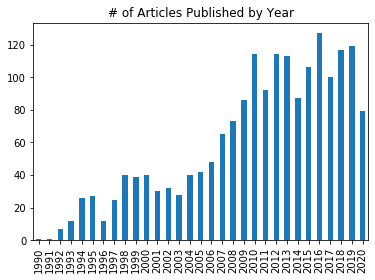

In [15]:
year = pandas.DataFrame(lists)
axyear=year.plot.bar(x=0, y=1, rot=90, legend=False)
axyear.xaxis.set_label_text("")
plt.title('# of Articles Published by Year')
